In [1625]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, f_oneway

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from category_encoders import TargetEncoder, OneHotEncoder as ce_OneHotEncoder

from sklearn.model_selection import train_test_split, RepeatedKFold, RepeatedStratifiedKFold, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline


In [1521]:
df = pd.read_csv('./Data/License_Data.csv', low_memory=False)
display(df.head(), df.shape)

,ID,LICENSE ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,ADDRESS,CITY,STATE,ZIP CODE,...,LICENSE TERM START DATE,LICENSE TERM EXPIRATION DATE,LICENSE APPROVED FOR ISSUANCE,DATE ISSUED,LICENSE STATUS CHANGE DATE,SSA,LATITUDE,LONGITUDE,LOCATION,LICENSE STATUS
0,35342-20020816,1256593,32811,1,CARMEN CAHUE,CLAUDIA'S BRIDAL SHOP,2625 S CENTRAL PARK AVE 1,CHICAGO,IL,60623.0,...,2002-08-16T00:00:00,2003-08-15T00:00:00,2002-08-21T00:00:00,2006-04-11T00:00:00,NaN,25.0,41.843613,-87.714618,"{'latitude': '41.843612879431845', 'longitude'...",AAI
1,1358463-20051116,1639294,262311,29,"ISLA TROPICAL, INC.",ISLA TROPICAL,2825 W MONTROSE AVE,CHICAGO,IL,60618,...,2005-11-16T00:00:00,2006-11-15T00:00:00,2006-04-05T00:00:00,2006-06-12T00:00:00,2006-06-15T00:00:00,60.0,41.961132,-87.699626,"{'latitude': '41.96113244107215', 'longitude':...",AAC
2,1980233-20090722,1980233,345008,1,DJS REMODELING,"DJS REMODELING, INC.",1605 CLAVEY RD 1,HIGHLAND,IL,60035,...,2009-07-22T00:00:00,2011-07-15T00:00:00,2009-07-22T00:00:00,2009-07-22T00:00:00,NaN,NaN,NaN,NaN,NaN,AAI
3,1476582-20040211,1476582,273121,1,ALL-BRY CONSTRUCTION CO.,ALL-BRY CONSTRUCTION CO.,8 NORTH TRAIL,LEMONT,IL,60439,...,2004-02-11T00:00:00,2005-02-15T00:00:00,2004-02-10T00:00:00,2004-02-11T00:00:00,NaN,NaN,NaN,NaN,NaN,AAI
4,1141408-20080516,1896750,213785,1,MCDONOUGH MECHANICAL SERVICE,MCDONOUGH MECHANICAL SERVICE,4081 JOSEPH DR,WAUKEGAN,IL,60087,...,2008-05-16T00:00:00,2010-05-15T00:00:00,2008-06-04T00:00:00,2008-06-05T00:00:00,NaN,NaN,NaN,NaN,NaN,AAI


(85895, 32)

In [1522]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85895 entries, 0 to 85894
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ID                                 85895 non-null  object 
 1   LICENSE ID                         85895 non-null  int64  
 2   ACCOUNT NUMBER                     85895 non-null  int64  
 3   SITE NUMBER                        85895 non-null  int64  
 4   LEGAL NAME                         85895 non-null  object 
 5   DOING BUSINESS AS NAME             85894 non-null  object 
 6   ADDRESS                            85895 non-null  object 
 7   CITY                               85895 non-null  object 
 8   STATE                              85895 non-null  object 
 9   ZIP CODE                           85864 non-null  object 
 10  WARD                               36194 non-null  float64
 11  PRECINCT                           29194 non-null  flo

In [1523]:
df['LICENSE STATUS'].value_counts()

AAI    55400
AAC    30200
REV      290
REA        3
INQ        2
Name: LICENSE STATUS, dtype: int64

In [1524]:
new_col_name = [col.replace(' ', '_').lower() for col in df.columns]
df.columns = new_col_name
df.columns

Index(['id', 'license_id', 'account_number', 'site_number', 'legal_name',
       'doing_business_as_name', 'address', 'city', 'state', 'zip_code',
       'ward', 'precinct', 'ward_precinct', 'police_district', 'license_code',
       'license_description', 'license_number', 'application_type',
       'application_created_date', 'application_requirements_complete',
       'payment_date', 'conditional_approval', 'license_term_start_date',
       'license_term_expiration_date', 'license_approved_for_issuance',
       'date_issued', 'license_status_change_date', 'ssa', 'latitude',
       'longitude', 'location', 'license_status'],
      dtype='object')

In [1525]:
df['license_description'].value_counts()

Limited Business License                    50078
Home Repair                                 10633
Peddler, non-food                            2812
Home Occupation                              2809
Retail Food Establishment                    2321
                                            ...  
Indoor Special Event                            1
Affiliation                                     1
Airport Pushcart Liquor Midway - Class A        1
Not-For-Profit Club                             1
Motor Vehicle Services License                  1
Name: license_description, Length: 106, dtype: int64

In [1526]:
df['license_description'].value_counts(normalize=True)[:10]

Limited Business License             0.583014
Home Repair                          0.123791
Peddler, non-food                    0.032738
Home Occupation                      0.032703
Retail Food Establishment            0.027021
Massage Therapist                    0.022725
Street Performer                     0.021992
Scavenger, Private                   0.018034
Hazardous Materials                  0.013109
Residential Real Estate Developer    0.012655
Name: license_description, dtype: float64

## Univariate Analysis

<Axes: >

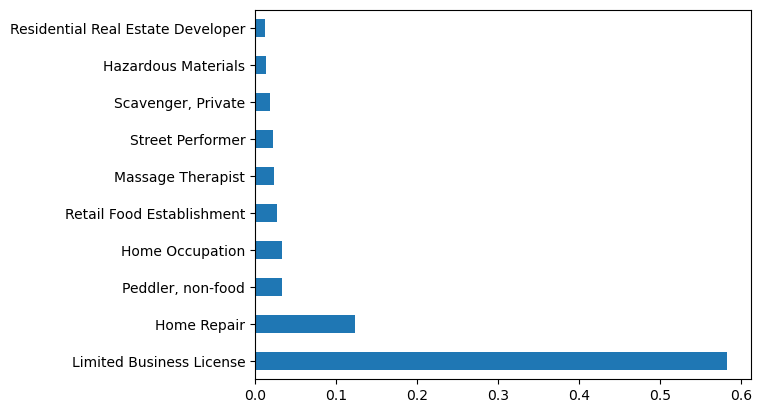

In [1527]:
df['license_description'].value_counts(normalize=True)[:10].plot(kind='barh')

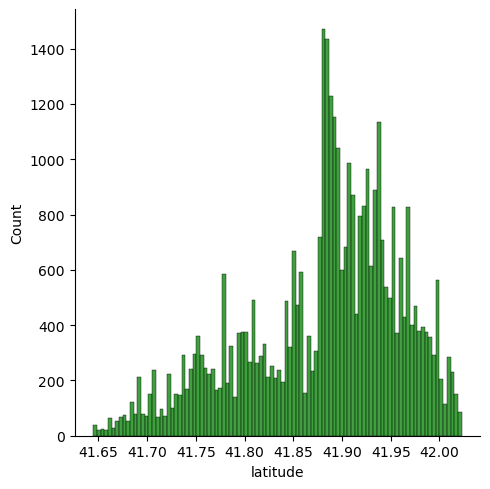

In [1528]:
sns.displot(df['latitude'], color='g', bins=100)

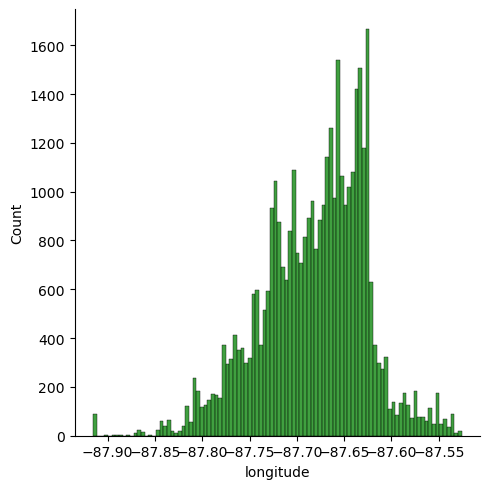

In [1529]:
sns.displot(df['longitude'], color='g', bins=100)

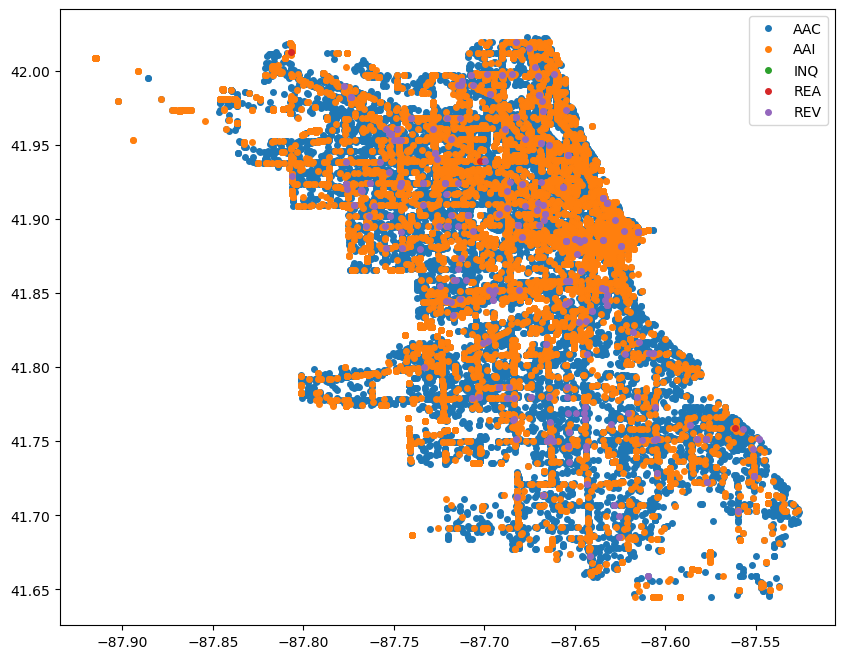

In [1530]:
sdf = df[['longitude', 'latitude', 'license_status']]
groups = sdf.groupby('license_status')

fig, ax = plt.subplots(figsize=(10, 8))
for name, group in groups:
    ax.plot(group.longitude, group.latitude, marker='o', linestyle='', ms=4, label=name)
ax.legend()
plt.show()

In [1531]:
pd.crosstab(df['license_status'], df['conditional_approval'])

conditional_approval,N,Y
license_status,,
AAC,30182,18
AAI,55400,0
INQ,2,0
REA,3,0
REV,290,0


## Data Cleansing

In [1532]:
for col in df.columns:
    n = df[col].isna().sum()
    perc = n / df.shape[0] * 100
    if n > 0:
      print(f'{col} - {n} - {perc:.2f}%')

doing_business_as_name - 1 - 0.00%
zip_code - 31 - 0.04%
ward - 49701 - 57.86%
precinct - 56701 - 66.01%
ward_precinct - 49700 - 57.86%
police_district - 54012 - 62.88%
license_number - 1 - 0.00%
application_created_date - 64660 - 75.28%
application_requirements_complete - 214 - 0.25%
payment_date - 1289 - 1.50%
license_term_start_date - 228 - 0.27%
license_term_expiration_date - 18 - 0.02%
license_approved_for_issuance - 6789 - 7.90%
license_status_change_date - 55400 - 64.50%
ssa - 76446 - 89.00%
latitude - 47246 - 55.00%
longitude - 47246 - 55.00%
location - 47246 - 55.00%


In [1533]:
# Drop irrelevant columns or columns with too many missing values
drop_col_list = ['id', 'license_id', 'account_number', 'ssa', 'location', 'application_created_date', 'address']
df = df.drop(drop_col_list, axis=1)

In [1534]:
def impute_missing_data(df):
    df_miss_cat = df.select_dtypes(include='object')
    df_miss_num = df.select_dtypes(exclude='object')
    imputer = SimpleImputer(strategy='most_frequent')
    df_miss_cat = pd.DataFrame(imputer.fit_transform(df_miss_cat), columns=df_miss_cat.columns)
    imputer = SimpleImputer(strategy='median')
    df_miss_num = pd.DataFrame(imputer.fit_transform(df_miss_num), columns=df_miss_num.columns)
    df = pd.concat([df_miss_num, df_miss_cat], axis=1)
    return df

In [1535]:
df_imputed = impute_missing_data(df)
df_imputed.isna().sum().sum()

0

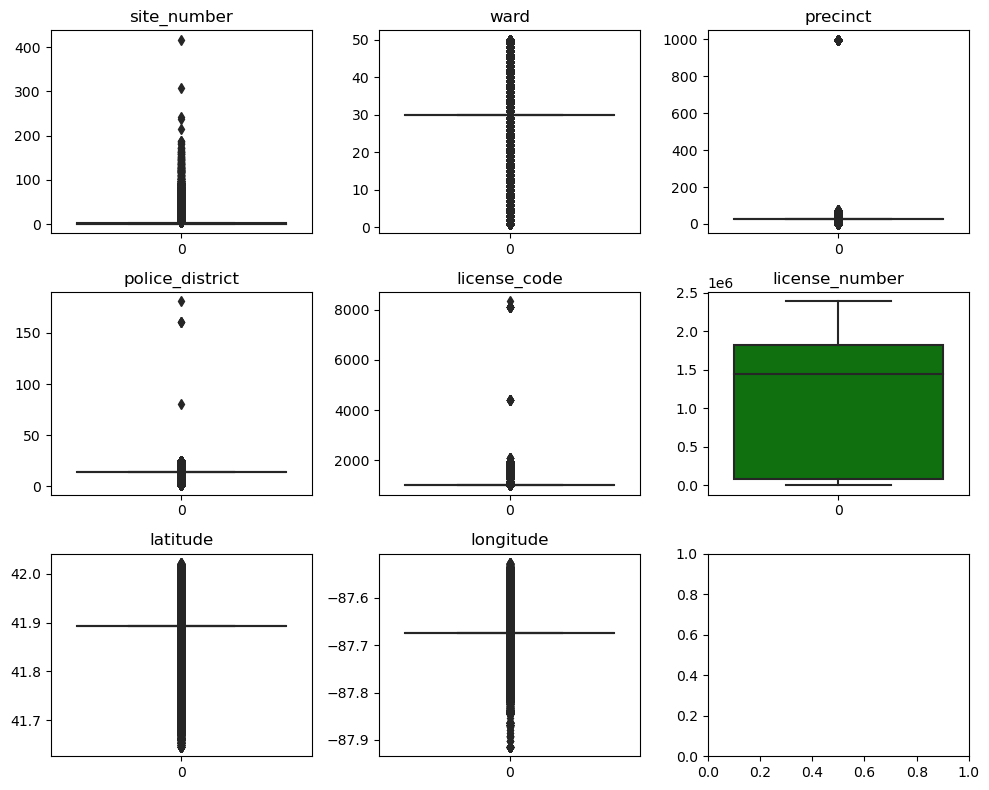

In [1536]:
df_num = df_imputed.select_dtypes(exclude='object')

fig, ax = plt.subplots(3, 3, figsize=(10, 8))

for i, col in enumerate(df_num.columns):
    sns.boxplot(df_num[col], ax=ax[i//3, i%3], color='g')
    ax[i//3, i%3].set_title(col)

plt.tight_layout()
plt.show()

In [1537]:
def std_outlier_removal(data, column, threshold):
  data_mean = data[column].mean()
  data_std =  data[column].std()
  cut_off = data_std * threshold

  lower = data_mean - cut_off
  upper = data_mean + cut_off

  outliers = [x for x in data[column] if x < lower or x > upper]
  print('{}'.format(column))
  print('Identified outliers: %d' % len(outliers))
  
  outliers_removed = [x for x in data[column] if x >= lower and x <= upper]
  print('Non-outlier observations: %d' % len(outliers_removed))

  print('\n')
  df_outliers_removed = data.loc[~data[column].isin(outliers)]
  return df_outliers_removed

In [1538]:
df_std = df_num.copy()
df_out_rem1 = std_outlier_removal(df_std, 'site_number', 3)
df_out_rem2 = std_outlier_removal(df_out_rem1, 'precinct', 3)
df_out_rem3 = std_outlier_removal(df_out_rem2, 'police_district', 3)
df_out_rem4 = std_outlier_removal(df_out_rem3, 'license_code', 3)
df_out_rem5 = std_outlier_removal(df_out_rem4, 'latitude', 3)
df_out_rem_final = std_outlier_removal(df_out_rem5, 'longitude', 3)

site_number
Identified outliers: 1121
Non-outlier observations: 84774


precinct
Identified outliers: 838
Non-outlier observations: 83936


police_district
Identified outliers: 5
Non-outlier observations: 83931


license_code
Identified outliers: 285
Non-outlier observations: 83646


latitude
Identified outliers: 1849
Non-outlier observations: 81797


longitude
Identified outliers: 1880
Non-outlier observations: 79917




In [1539]:
df['license_code'].value_counts()

1010    50078
1011    10633
1604     2812
1012     2809
1006     2321
        ...  
1058        1
1070        1
1686        1
1473        1
8340        1
Name: license_code, Length: 106, dtype: int64

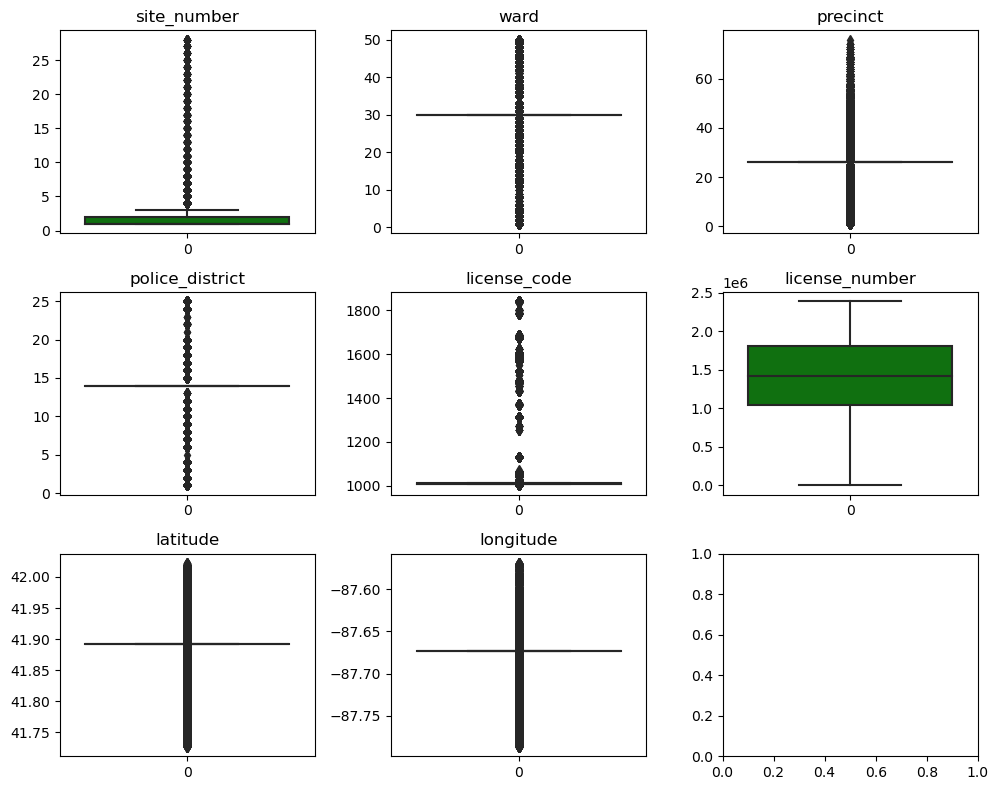

In [1540]:
# df_num = df_clean.select_dtypes(exclude='object')
# df_num.shape

fig, ax = plt.subplots(3, 3, figsize=(10, 8))

for i, col in enumerate(df_out_rem_final.columns):
    sns.boxplot(df_out_rem_final[col], ax=ax[i//3, i%3], color='g')
    ax[i//3, i%3].set_title(col)

plt.tight_layout()
plt.show()

In [1541]:
def merge_num_cat(df_cat, df_outliers_rem):
  df_cat_std = df_cat.loc[df_outliers_rem.index]
  df_std = pd.concat([df_outliers_rem, df_cat_std], axis=1)
  df_std = df_std.reset_index(drop=True)

  return df_std

df_cleaned = merge_num_cat(df_imputed.select_dtypes(include='object'), df_out_rem_final)
display(df_cleaned.head(), df_cleaned.shape)

,site_number,ward,precinct,police_district,license_code,license_number,latitude,longitude,legal_name,doing_business_as_name,...,application_type,application_requirements_complete,payment_date,conditional_approval,license_term_start_date,license_term_expiration_date,license_approved_for_issuance,date_issued,license_status_change_date,license_status
0,1.0,22.0,28.0,10.0,1010.0,35342.0,41.843613,-87.714618,CARMEN CAHUE,CLAUDIA'S BRIDAL SHOP,...,RENEW,2002-06-28T00:00:00,2002-08-21T00:00:00,N,2002-08-16T00:00:00,2003-08-15T00:00:00,2002-08-21T00:00:00,2006-04-11T00:00:00,2012-12-29T00:00:00,AAI
1,1.0,30.0,26.0,14.0,1011.0,1980233.0,41.892679,-87.673321,DJS REMODELING,"DJS REMODELING, INC.",...,ISSUE,2009-07-22T00:00:00,2009-07-22T00:00:00,N,2009-07-22T00:00:00,2011-07-15T00:00:00,2009-07-22T00:00:00,2009-07-22T00:00:00,2012-12-29T00:00:00,AAI
2,1.0,30.0,26.0,14.0,1010.0,1476582.0,41.892679,-87.673321,ALL-BRY CONSTRUCTION CO.,ALL-BRY CONSTRUCTION CO.,...,ISSUE,2004-02-10T00:00:00,2004-02-10T00:00:00,N,2004-02-11T00:00:00,2005-02-15T00:00:00,2004-02-10T00:00:00,2004-02-11T00:00:00,2012-12-29T00:00:00,AAI
3,1.0,30.0,26.0,14.0,1010.0,1141408.0,41.892679,-87.673321,MCDONOUGH MECHANICAL SERVICE,MCDONOUGH MECHANICAL SERVICE,...,RENEW,2008-03-24T00:00:00,2008-06-04T00:00:00,N,2008-05-16T00:00:00,2010-05-15T00:00:00,2008-06-04T00:00:00,2008-06-05T00:00:00,2012-12-29T00:00:00,AAI
4,1.0,30.0,26.0,14.0,1010.0,2129534.0,41.892679,-87.673321,QUALITY PLUMBING SERVICES INC.,QUALITY PLUMBING SERVICES INC.,...,ISSUE,2011-11-28T00:00:00,2011-11-28T00:00:00,N,2011-11-29T00:00:00,2013-12-15T00:00:00,2011-11-28T00:00:00,2011-11-29T00:00:00,2012-12-29T00:00:00,AAI


(79917, 25)

## Data Transforms

In [1542]:
# convert string object into date
df_cleaned['application_requirements_complete'] = pd.DatetimeIndex(df_cleaned['application_requirements_complete'])
df_cleaned['payment_date'] = pd.DatetimeIndex(df_cleaned['payment_date'])
df_cleaned['license_term_start_date'] = pd.DatetimeIndex(df_cleaned['license_term_start_date'])
df_cleaned['license_term_expiration_date'] = pd.DatetimeIndex(df_cleaned['license_term_expiration_date'])
df_cleaned['license_approved_for_issuance'] = pd.DatetimeIndex(df_cleaned['license_approved_for_issuance'])
df_cleaned['date_issued']= pd.DatetimeIndex(df_cleaned['date_issued'])
df_cleaned['license_status_change_date'] = pd.DatetimeIndex(df_cleaned['license_status_change_date'])

In [1543]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79917 entries, 0 to 79916
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   site_number                        79917 non-null  float64       
 1   ward                               79917 non-null  float64       
 2   precinct                           79917 non-null  float64       
 3   police_district                    79917 non-null  float64       
 4   license_code                       79917 non-null  float64       
 5   license_number                     79917 non-null  float64       
 6   latitude                           79917 non-null  float64       
 7   longitude                          79917 non-null  float64       
 8   legal_name                         79917 non-null  object        
 9   doing_business_as_name             79917 non-null  object        
 10  city                              

In [1544]:
# Find no.of days btw different application status date
df_cleaned["completion_to_start"] = (df_cleaned['license_term_start_date']- df_cleaned['application_requirements_complete']).dt.days
df_cleaned["start_to_expiry"] =  (df_cleaned['license_term_expiration_date'] - df_cleaned['license_term_start_date']).dt.days
df_cleaned["approval_to_issuance"] = (df_cleaned['date_issued'] - df_cleaned['license_approved_for_issuance']).dt.days
df_cleaned["completion_to_payment"] = (df_cleaned['payment_date'] - df_cleaned['application_requirements_complete']).dt.days

df_cleaned["target"] = df_cleaned[['license_status']].apply(lambda col:pd.Categorical(col).codes)

In [1545]:
df_cleaned.head()


,site_number,ward,precinct,police_district,license_code,license_number,latitude,longitude,legal_name,doing_business_as_name,...,license_term_expiration_date,license_approved_for_issuance,date_issued,license_status_change_date,license_status,completion_to_start,start_to_expiry,approval_to_issuance,completion_to_payment,target
0,1.0,22.0,28.0,10.0,1010.0,35342.0,41.843613,-87.714618,CARMEN CAHUE,CLAUDIA'S BRIDAL SHOP,...,2003-08-15,2002-08-21,2006-04-11,2012-12-29,AAI,49,364,1329,54,1
1,1.0,30.0,26.0,14.0,1011.0,1980233.0,41.892679,-87.673321,DJS REMODELING,"DJS REMODELING, INC.",...,2011-07-15,2009-07-22,2009-07-22,2012-12-29,AAI,0,723,0,0,1
2,1.0,30.0,26.0,14.0,1010.0,1476582.0,41.892679,-87.673321,ALL-BRY CONSTRUCTION CO.,ALL-BRY CONSTRUCTION CO.,...,2005-02-15,2004-02-10,2004-02-11,2012-12-29,AAI,1,370,1,0,1
3,1.0,30.0,26.0,14.0,1010.0,1141408.0,41.892679,-87.673321,MCDONOUGH MECHANICAL SERVICE,MCDONOUGH MECHANICAL SERVICE,...,2010-05-15,2008-06-04,2008-06-05,2012-12-29,AAI,53,729,1,72,1
4,1.0,30.0,26.0,14.0,1010.0,2129534.0,41.892679,-87.673321,QUALITY PLUMBING SERVICES INC.,QUALITY PLUMBING SERVICES INC.,...,2013-12-15,2011-11-28,2011-11-29,2012-12-29,AAI,1,747,1,0,1


In [1546]:
df_cleaned = df_cleaned.drop(['license_status', 'license_term_start_date', 'application_requirements_complete',
'license_term_expiration_date', 'date_issued', 'license_approved_for_issuance', 'payment_date', 'license_status_change_date'], axis=1)

In [1547]:
display(df_cleaned.head(), df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79917 entries, 0 to 79916
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   site_number             79917 non-null  float64
 1   ward                    79917 non-null  float64
 2   precinct                79917 non-null  float64
 3   police_district         79917 non-null  float64
 4   license_code            79917 non-null  float64
 5   license_number          79917 non-null  float64
 6   latitude                79917 non-null  float64
 7   longitude               79917 non-null  float64
 8   legal_name              79917 non-null  object 
 9   doing_business_as_name  79917 non-null  object 
 10  city                    79917 non-null  object 
 11  state                   79917 non-null  object 
 12  zip_code                79917 non-null  object 
 13  ward_precinct           79917 non-null  object 
 14  license_description     79917 non-null

,site_number,ward,precinct,police_district,license_code,license_number,latitude,longitude,legal_name,doing_business_as_name,...,zip_code,ward_precinct,license_description,application_type,conditional_approval,completion_to_start,start_to_expiry,approval_to_issuance,completion_to_payment,target
0,1.0,22.0,28.0,10.0,1010.0,35342.0,41.843613,-87.714618,CARMEN CAHUE,CLAUDIA'S BRIDAL SHOP,...,60623.0,22-28,Limited Business License,RENEW,N,49,364,1329,54,1
1,1.0,30.0,26.0,14.0,1011.0,1980233.0,41.892679,-87.673321,DJS REMODELING,"DJS REMODELING, INC.",...,60035,42-,Home Repair,ISSUE,N,0,723,0,0,1
2,1.0,30.0,26.0,14.0,1010.0,1476582.0,41.892679,-87.673321,ALL-BRY CONSTRUCTION CO.,ALL-BRY CONSTRUCTION CO.,...,60439,42-,Limited Business License,ISSUE,N,1,370,1,0,1
3,1.0,30.0,26.0,14.0,1010.0,1141408.0,41.892679,-87.673321,MCDONOUGH MECHANICAL SERVICE,MCDONOUGH MECHANICAL SERVICE,...,60087,42-,Limited Business License,RENEW,N,53,729,1,72,1
4,1.0,30.0,26.0,14.0,1010.0,2129534.0,41.892679,-87.673321,QUALITY PLUMBING SERVICES INC.,QUALITY PLUMBING SERVICES INC.,...,60191,42-,Limited Business License,ISSUE,N,1,747,1,0,1


None

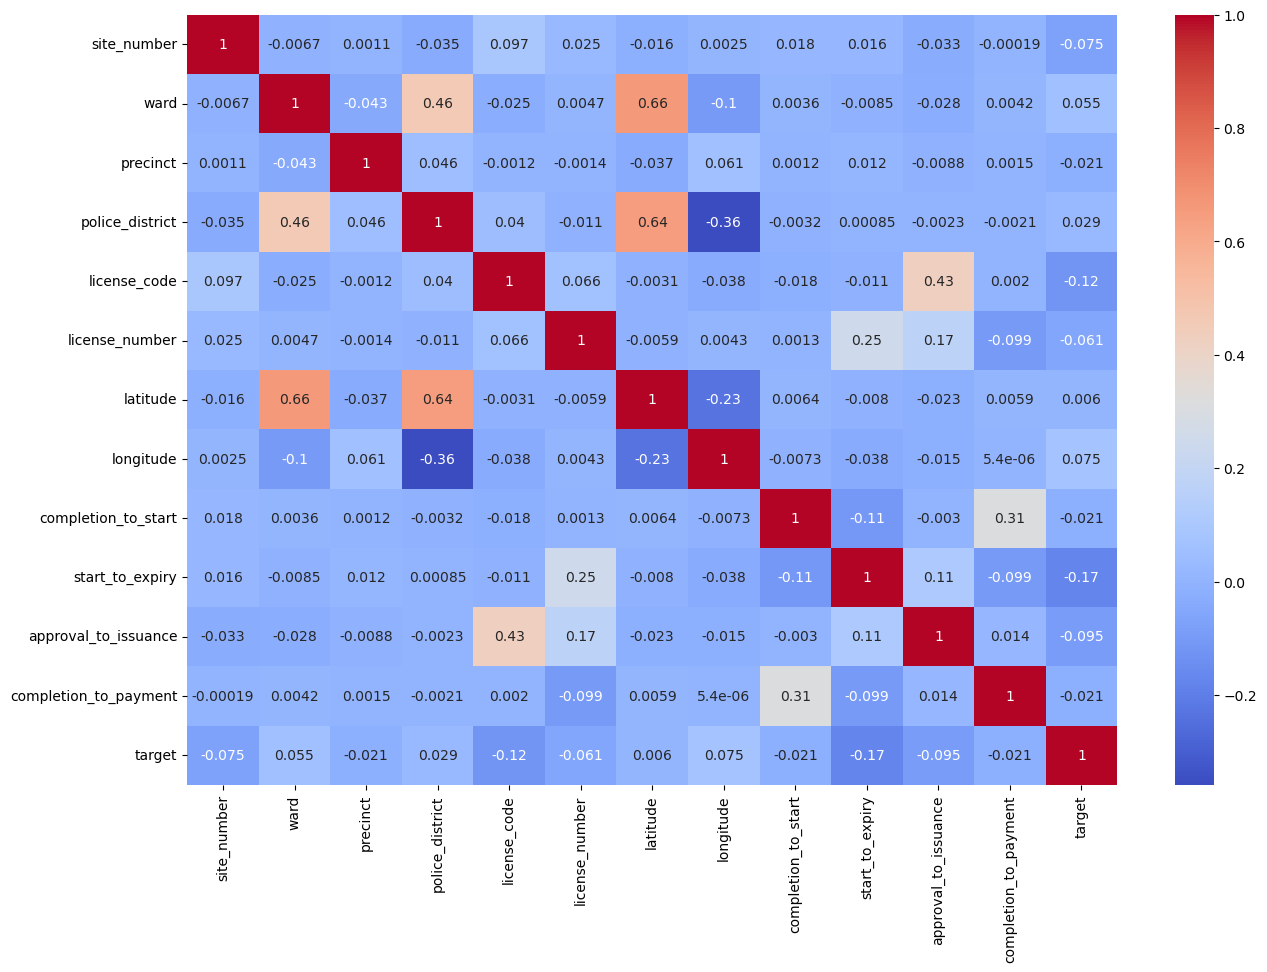

In [1548]:
df_num = df_cleaned.select_dtypes(exclude='object')
df_corr = df_num.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(df_corr, annot=True, cmap='coolwarm')
plt.show()

In [1549]:
df_final = df_cleaned.drop(['ward', 'police_district'], axis=1)
df_final.head()

,site_number,precinct,license_code,license_number,latitude,longitude,legal_name,doing_business_as_name,city,state,zip_code,ward_precinct,license_description,application_type,conditional_approval,completion_to_start,start_to_expiry,approval_to_issuance,completion_to_payment,target
0,1.0,28.0,1010.0,35342.0,41.843613,-87.714618,CARMEN CAHUE,CLAUDIA'S BRIDAL SHOP,CHICAGO,IL,60623.0,22-28,Limited Business License,RENEW,N,49,364,1329,54,1
1,1.0,26.0,1011.0,1980233.0,41.892679,-87.673321,DJS REMODELING,"DJS REMODELING, INC.",HIGHLAND,IL,60035,42-,Home Repair,ISSUE,N,0,723,0,0,1
2,1.0,26.0,1010.0,1476582.0,41.892679,-87.673321,ALL-BRY CONSTRUCTION CO.,ALL-BRY CONSTRUCTION CO.,LEMONT,IL,60439,42-,Limited Business License,ISSUE,N,1,370,1,0,1
3,1.0,26.0,1010.0,1141408.0,41.892679,-87.673321,MCDONOUGH MECHANICAL SERVICE,MCDONOUGH MECHANICAL SERVICE,WAUKEGAN,IL,60087,42-,Limited Business License,RENEW,N,53,729,1,72,1
4,1.0,26.0,1010.0,2129534.0,41.892679,-87.673321,QUALITY PLUMBING SERVICES INC.,QUALITY PLUMBING SERVICES INC.,WOOD DALE,IL,60191,42-,Limited Business License,ISSUE,N,1,747,1,0,1


### Categorical Variable significance

In [1550]:
df_cat = df_final.select_dtypes(include='object')
df_cat.columns


Index(['legal_name', 'doing_business_as_name', 'city', 'state', 'zip_code',
       'ward_precinct', 'license_description', 'application_type',
       'conditional_approval'],
      dtype='object')

In [1551]:
# H0: There is no association between [col] and target
# result

In [1552]:
def cat_significance(df):
  for col in df_cat.columns:
    annova_prep_res = df_final.groupby(col)['target'].apply(list)
    annova_res = f_oneway(*annova_prep_res)
    print('p-value of {}: {}'.format(col, annova_res[1]))

    if annova_res[1] < 0.05:
      print('There is an association between {} and target'.format(col))
    else:
      print('There is no association between {} and target'.format(col))
    print('\n')

In [1553]:
cat_significance(df_cat)

p-value of legal_name: 0.0
There is an association between legal_name and target


p-value of doing_business_as_name: 0.0
There is an association between doing_business_as_name and target


p-value of city: 0.0
There is an association between city and target


p-value of state: 5.076568904498258e-217
There is an association between state and target


p-value of zip_code: 0.0
There is an association between zip_code and target


p-value of ward_precinct: 0.0
There is an association between ward_precinct and target


p-value of license_description: 0.0
There is an association between license_description and target


p-value of application_type: 2.4267964368192646e-27
There is an association between application_type and target


p-value of conditional_approval: 1.9747326721293348e-08
There is an association between conditional_approval and target




In [1554]:
df_final = df_final.drop(['legal_name', 'doing_business_as_name', 'ward_precinct'], axis=1)
df_final.head()

,site_number,precinct,license_code,license_number,latitude,longitude,city,state,zip_code,license_description,application_type,conditional_approval,completion_to_start,start_to_expiry,approval_to_issuance,completion_to_payment,target
0,1.0,28.0,1010.0,35342.0,41.843613,-87.714618,CHICAGO,IL,60623.0,Limited Business License,RENEW,N,49,364,1329,54,1
1,1.0,26.0,1011.0,1980233.0,41.892679,-87.673321,HIGHLAND,IL,60035,Home Repair,ISSUE,N,0,723,0,0,1
2,1.0,26.0,1010.0,1476582.0,41.892679,-87.673321,LEMONT,IL,60439,Limited Business License,ISSUE,N,1,370,1,0,1
3,1.0,26.0,1010.0,1141408.0,41.892679,-87.673321,WAUKEGAN,IL,60087,Limited Business License,RENEW,N,53,729,1,72,1
4,1.0,26.0,1010.0,2129534.0,41.892679,-87.673321,WOOD DALE,IL,60191,Limited Business License,ISSUE,N,1,747,1,0,1


### Feature Scaling

In [1555]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79917 entries, 0 to 79916
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   site_number            79917 non-null  float64
 1   precinct               79917 non-null  float64
 2   license_code           79917 non-null  float64
 3   license_number         79917 non-null  float64
 4   latitude               79917 non-null  float64
 5   longitude              79917 non-null  float64
 6   city                   79917 non-null  object 
 7   state                  79917 non-null  object 
 8   zip_code               79917 non-null  object 
 9   license_description    79917 non-null  object 
 10  application_type       79917 non-null  object 
 11  conditional_approval   79917 non-null  object 
 12  completion_to_start    79917 non-null  int64  
 13  start_to_expiry        79917 non-null  int64  
 14  approval_to_issuance   79917 non-null  int64  
 15  co

In [1556]:
df_final['license_description'].value_counts()

Limited Business License                    47199
Home Repair                                 10264
Peddler, non-food                            2707
Home Occupation                              2455
Retail Food Establishment                    2059
                                            ...  
Indoor Special Event                            1
Caterer's Registration (Liquor)                 1
Affiliation                                     1
Airport Pushcart Liquor Midway - Class A        1
Not-For-Profit Club                             1
Name: license_description, Length: 95, dtype: int64

In [1557]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79917 entries, 0 to 79916
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   site_number            79917 non-null  float64
 1   precinct               79917 non-null  float64
 2   license_code           79917 non-null  float64
 3   license_number         79917 non-null  float64
 4   latitude               79917 non-null  float64
 5   longitude              79917 non-null  float64
 6   city                   79917 non-null  object 
 7   state                  79917 non-null  object 
 8   zip_code               79917 non-null  object 
 9   license_description    79917 non-null  object 
 10  application_type       79917 non-null  object 
 11  conditional_approval   79917 non-null  object 
 12  completion_to_start    79917 non-null  int64  
 13  start_to_expiry        79917 non-null  int64  
 14  approval_to_issuance   79917 non-null  int64  
 15  co

In [1558]:
df_final['conditional_approval'].replace({'N':0, 'Y':1}, inplace=True)

In [1559]:
X = df_final.drop('target', axis=1)
y = df_final['target']

In [1560]:
# apply target encoding to these categorical features (license_description, state, city)
# target encoding
from category_encoders import TargetEncoder
encoder = TargetEncoder(cols=['license_description', 'state', 'city'])
X = encoder.fit_transform(X, y)


In [1561]:
enc = ce_OneHotEncoder().fit(df_final.target.astype(str))
y_onehot = enc.transform(df_final.target.astype(str))
print(y_onehot.columns)

Index(['target_1', 'target_2', 'target_3', 'target_4', 'target_5'], dtype='object')


In [1562]:
enc = ce_OneHotEncoder().fit(df_final.target.astype(str))
y_onehot = enc.transform(df_final.target.astype(str))

class_names=y_onehot.columns
for class_ in class_names:
  enc = TargetEncoder(smoothing=0)
  temp = enc.fit_transform(df_final[["license_description","state","city"]] ,y_onehot[class_])
  temp.columns = [str(x)+'_'+str(class_) for x in temp.columns]
  df_final = pd.concat([df_final, temp],axis=1)

In [1563]:
df_final.head()

,site_number,precinct,license_code,license_number,latitude,longitude,city,state,zip_code,license_description,...,city_target_2,license_description_target_3,state_target_3,city_target_3,license_description_target_4,state_target_4,city_target_4,license_description_target_5,state_target_5,city_target_5
0,1.0,28.0,1010.0,35342.0,41.843613,-87.714618,CHICAGO,IL,60623.0,Limited Business License,...,0.721027,0.001081,0.003553,0.008449,0.000021,0.000027,0.0,0.0,0.000013,0.000032
1,1.0,26.0,1011.0,1980233.0,41.892679,-87.673321,HIGHLAND,IL,60035,Home Repair,...,0.192308,0.000000,0.003553,0.000000,0.000097,0.000027,0.0,0.0,0.000013,0.000000
2,1.0,26.0,1010.0,1476582.0,41.892679,-87.673321,LEMONT,IL,60439,Limited Business License,...,0.067278,0.001081,0.003553,0.000000,0.000021,0.000027,0.0,0.0,0.000013,0.000000
3,1.0,26.0,1010.0,1141408.0,41.892679,-87.673321,WAUKEGAN,IL,60087,Limited Business License,...,0.055901,0.001081,0.003553,0.000000,0.000021,0.000027,0.0,0.0,0.000013,0.000000
4,1.0,26.0,1010.0,2129534.0,41.892679,-87.673321,WOOD DALE,IL,60191,Limited Business License,...,0.049793,0.001081,0.003553,0.000000,0.000021,0.000027,0.0,0.0,0.000013,0.000000


## Handling class imbalance

In [1564]:
df_cleaned['target'].value_counts()

1    52805
0    26844
4      265
2        2
3        1
Name: target, dtype: int64

In [1565]:
df_0 = df_final[df_final['target'] == 0].sample(frac=0.3, replace=False)
df_1 = df_final[df_final['target'] == 1].sample(frac=0.3, replace=False)

df_2 = df_final[df_final['target'] == 2].sample(frac=200, replace=True)
df_3 = df_final[df_final['target'] == 3].sample(frac=100, replace=True)
df_4 = df_final[df_final['target'] == 4].sample(frac=2, replace=True)

df_sampled = pd.concat([df_0, df_1, df_2, df_3, df_4], axis=0)

df_sampled['target'].value_counts()
# df_sampled['target'].value_counts()

1    15842
0     8053
4      530
2      400
3      100
Name: target, dtype: int64

In [1583]:
X = df_sampled[['latitude', 'longitude',
       'completion_to_start',
       'start_to_expiry', 'approval_to_issuance', 'completion_to_payment',
       'license_description_target_1',
       'state_target_1', 'city_target_1', 'license_description_target_2',
       'state_target_2', 'city_target_2', 'license_description_target_3',
       'state_target_3', 'city_target_3', 'license_description_target_4',
       'state_target_4', 'city_target_4', 'license_description_target_5',
       'state_target_5', 'city_target_5']]

y = df_sampled['target']

In [1639]:
df_sampled = df_sampled[['latitude', 'longitude',
       'completion_to_start',
       'start_to_expiry', 'approval_to_issuance', 'completion_to_payment',
       'license_description_target_1',
       'state_target_1', 'city_target_1', 'license_description_target_2',
       'state_target_2', 'city_target_2', 'license_description_target_3',
       'state_target_3', 'city_target_3', 'license_description_target_4',
       'state_target_4', 'city_target_4', 'license_description_target_5',
       'state_target_5', 'city_target_5']]

In [1588]:
X = X.fillna(X.mean())

In [1604]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [1628]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [1613]:
models = [('lr', LogisticRegression(max_iter=1000)), ('knn', KNeighborsClassifier()), ('rf', RandomForestClassifier()),
          ('dt', DecisionTreeClassifier()), ('gbr', GradientBoostingClassifier()), ('mlp', MLPClassifier(max_iter=1000)),
          ('svc', SVC()), ('xgb', XGBClassifier())]

In [1622]:
def model_selection(X, y, model):
    scores = []
    names = []

    for name, model in models:
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123)
        cv_results = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
        print(f'{name}: {round(np.mean(cv_results), 4)} ({round(np.std(cv_results), 4)})')

In [1623]:
model_selection(X, y, models)

lr: 0.8391 (0.0069)
knn: 0.8618 (0.0065)
rf: 0.8866 (0.005)
dt: 0.848 (0.0065)
gbr: 0.8777 (0.0067)
mlp: 0.8572 (0.0051)
svc: 0.8465 (0.0073)
xgb: 0.8931 (0.0057)


## XGB Model

In [1630]:
xgb = XGBClassifier()

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))

Accuracy: 0.891013640010698


In [1631]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      2401
           1       0.92      0.92      0.92      4742
           2       1.00      1.00      1.00       128
           3       0.96      1.00      0.98        25
           4       0.92      0.90      0.91       182

    accuracy                           0.89      7478
   macro avg       0.93      0.93      0.93      7478
weighted avg       0.89      0.89      0.89      7478



## Hyperparam tuning

In [1650]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

xgb = XGBClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=cv)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}


In [1651]:
best_xgb = XGBClassifier(**best_params)

best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))

Accuracy: 0.8902112864402246


In [1653]:
def model_selection(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123)
    cv_results = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
    print(f'{name}: {round(np.mean(cv_results), 4)} ({round(np.std(cv_results), 4)})')

In [1654]:
model_selection(X, y, best_xgb)

REV: 0.8933 (0.0057)


In [1652]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      2401
           1       0.92      0.91      0.92      4742
           2       1.00      1.00      1.00       128
           3       1.00      1.00      1.00        25
           4       0.92      0.91      0.91       182

    accuracy                           0.89      7478
   macro avg       0.93      0.93      0.93      7478
weighted avg       0.89      0.89      0.89      7478



In [ ]:
model_selection()

In [1641]:
# Finding the variable with more importance
import pandas as pd

# Convert X_train to a DataFrame
X_train_df = pd.DataFrame(X_train, columns=df_sampled.columns)

# Create the feature importance DataFrame
feature_importance = pd.DataFrame({'Feature': X_train_df.columns, 'Importance': best_xgb.feature_importances_})

# Sort the feature importance by descending order
feature_importance = feature_importance.sort_values(by='Importance', ascending=False).head(10)


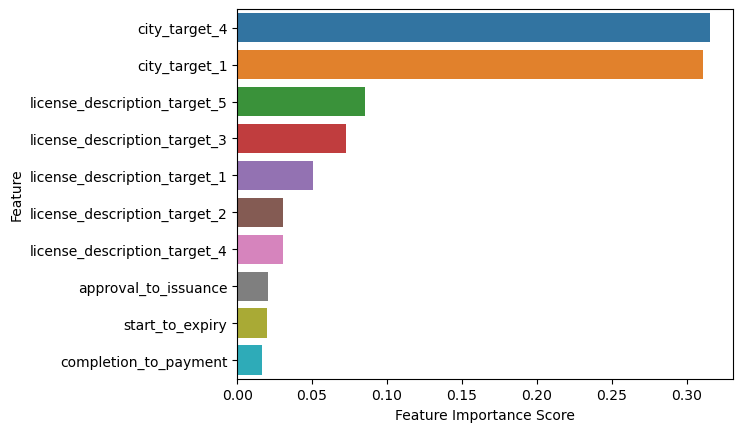

In [1644]:
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.xlabel('Feature Importance Score')
plt.show()
